In [2]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml
# from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

def get_Rij(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    R11 = dat[:,0]
    R12 = dat[:,1]
    R13 = dat[:,2]
    R22 = dat[:,3]
    R23 = dat[:,4]
    R33 = dat[:,5]
    return R11,R12,R13,R22,R23,R33

def get_corrsin(directory,flist,thresh=0.1):
    mat = np.zeros([len(flist),3])
    dir_out = directory
    
    for i,fname in enumerate(flist):
        tID = fname.split('_')[-1]
        tID = int(tID.split('.dat')[0])
        time = nml.read_time(directory,tID)

        # Get centerline
        ic,yc = get_centerline(directory,-y,tID)
         
        # Get integral lengthscale
        autocorr = np.fromfile(directory+'lscale_vv_%04d'%(tID)+'.dat',dtype=float,sep=' ')
        autocorr = np.reshape(autocorr,[Ny,3])
        autocorr = autocorr[:,0]
        L_int,tmp,tmp = get_lscale(y,autocorr,thresh=thresh)  
        
        # Get shear S
        utilde = np.fromfile(directory+'shearlayer_utilde_%04d'%(tID)+'.dat',dtype=float, count=-1, sep=' ')
        offset = 20
        i1 = ic-offset
        i2 = ic+offset
        dy = y[i1]-y[i2]
        S = (utilde[i1]-utilde[i2])/dy  
        
        # Get tke
        R11,R12,R13,R22,R23,R33 = get_Rij(directory+'shearlayer_Rij_%04d'%(tID)+'.dat')
        C1 = S*L_int/np.amax(np.sqrt(R11+R22+R33))
        C2 = S*L_int/np.amax(np.sqrt(abs(R22)))
        
        # Record for later
        mat[i,0] = time
        mat[i,1] = C1
        mat[i,2] = C2
        
    isort = np.argsort(mat[:,0]) #sort time
    return mat[isort,:]

directory = '/home/kmatsuno/ShearLayerData/production/Mc02/rr1/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)
dy = abs(y[0]-y[1])

flist = glob.glob(directory+"*lscale_vv*")
flist.sort()
print([f.split('/')[-1] for f in flist])

# And read growth rates
# tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 0.2
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['lscale_vv_0003.dat', 'lscale_vv_0004.dat', 'lscale_vv_0005.dat', 'lscale_vv_0012.dat', 'lscale_vv_0013.dat', 'lscale_vv_0014.dat', 'lscale_vv_0015.dat', 'lscale_vv_0016.dat', 'lscale_vv_0017.dat', 'lscale_vv_0018.dat', 'lscale_vv_0019.dat', 'lscale_vv_0020.dat', 'lscale_vv_0101.dat', 'lscale_vv_0102.dat', 'lscale_vv_0103.dat', 'lscale_vv_0104.dat', 'lscale_vv_0105.dat', 'lscale_vv_0106.dat', 'lscale_vv_0107.dat', 'lscale_vv_0108.dat', 'lscale_vv_0109.dat', 'lscale_vv_0110.dat', 'lscale_vv_0111.dat', 'lscale_vv_0112.dat', 'lscale_vv_0113.dat']


0.2:[2.07272227314,0.271641219096]
0.2:[4.27818640622,0.621345682277]
(0.2, 1.0)


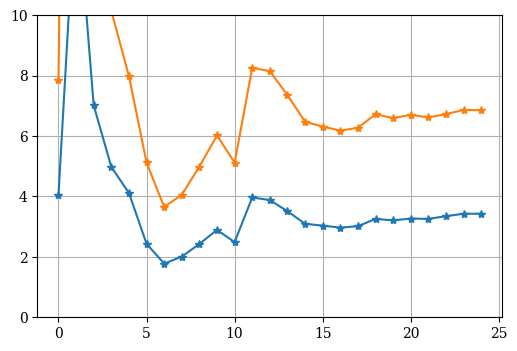

In [55]:
fig = plt.figure(dpi=100)
dat = get_corrsin(directory,flist[:])
plt.grid(True)
# plt.xlim([-20,20])
plt.plot(dat[:,1],'-*')
plt.plot(dat[:,2],'-*')

plt.ylim([0,10])
idx = 5
ie = 8
print('{}:[{},{}]'.format(inp.Mc,np.mean(dat[idx:ie,1]),np.std(dat[idx:ie,1])))
print('{}:[{},{}]'.format(inp.Mc,np.mean(dat[idx:ie,2]),np.std(dat[idx:ie,2])))
print(inp.Mc,inp.rr)

0.8:[3.71474691958,0.536411994971],
1.2:[3.47977721433,0.278062053781],
1.6:[3.90241395199,0.460703241338],
2.0:[3.88151171754,0.307073993864],


Text(0.5,0,'$t/\\Delta U$')

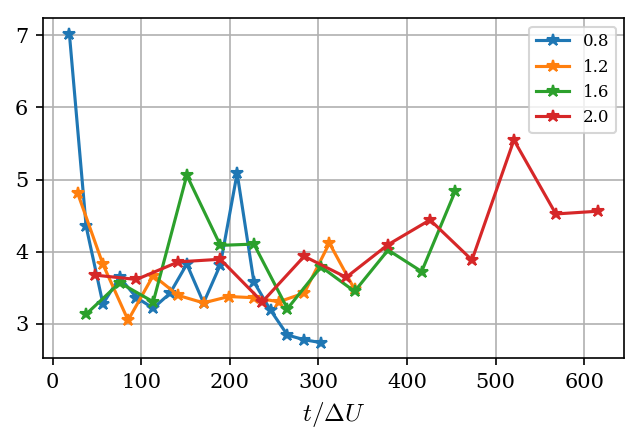

In [52]:
s = '1'

if s=='1': Mc_list = ['08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    if 0:#Mc is '04': or Mc is '02':
        dir_out = '/home/kmatsuno/ShearLayerData/temporal/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    else:
        dir_out = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    inp = nml.inputs(dir_out,verbose=False)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(dir_out,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    
    flist = glob.glob(dir_out+"*lscale_vv*")
    flist.sort()

    dat = get_corrsin(dir_out,flist,thresh=0.1)
    t = dat[:,0]*inp.du
    f = dat[:,2] # 1:SL/q, 2:SL/v'
    plt.plot(t,f,'-*',label='{}'.format(inp.Mc))
    
    if Mc=='02': ist=5;ien=8 # mira run
#     if Mc=='02': ist=14;ien=20 # theta run
    elif Mc=='04': ist=3;ien=17 #mira run
#     elif Mc=='04': ist=7;ien=10 #theta run
    elif Mc=='08': ist=1;ien=-4
    elif Mc=='12': ist=1;ien=None
    elif Mc=='16': ist=4;ien=None
    elif Mc=='20': ist=2;ien=-3
    else: ist=0; ien=None 
    print('{}:[{},{}],'.format(inp.Mc,np.mean(f[ist:ien]),np.std(f[ist:ien])))
    
plt.grid(True)
plt.legend()
plt.xlabel(r'$t/\Delta U$')
# plt.ylim([0.5,4])

Text(0.18,5.9,'(b)')

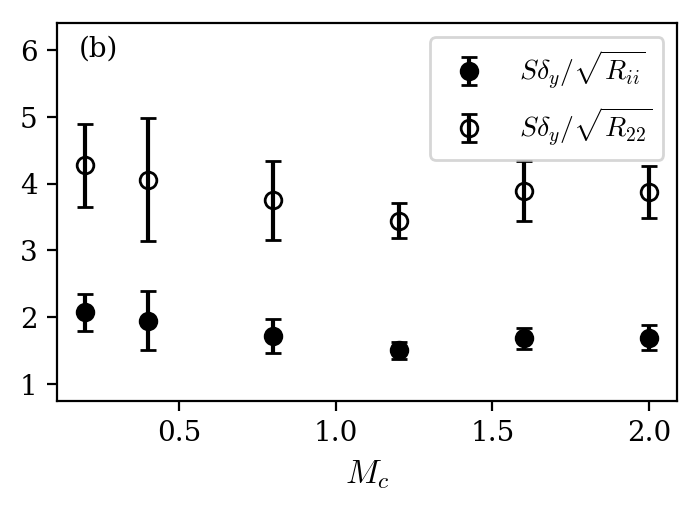

In [5]:
def plotter(dat,fmt,label,fillstyle='full'):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()],
        yerr=[x[1] for x in dat.values()],fmt=fmt,capsize=3,label=label,fillstyle=fillstyle)

fig = plt.figure(figsize=(4,2.5),dpi=200)
plotter(C['C1'],'ko',r'$S\delta_y/\sqrt{R_{ii}}$')
plotter(C['C2'],'ko',r'$S\delta_y/\sqrt{R_{22}}$',fillstyle='none')

# plt.ylabel(r'$R_{ij}/\Delta \bar{u}^2$')
plt.xlabel('$M_c$')
plt.legend(fontsize=10)#,bbox_to_anchor=(0.9,0.35))
plt.ylim([0.75,6.4])
plt.annotate('(b)',(0.18,5.9),fontsize=10)

In [4]:
C ={}
C['C1']= {
0.2:[2.07272227314,0.271641219096],
0.4:[1.94578124794,0.440032385576],
0.8:[1.71501161832,0.252393306215],
1.2:[1.50416511316,0.123981443779],
1.6:[1.68498953009,0.156858142001],
2.0:[1.6967925147,0.193244349025],   
}
C['C2'] = {
0.2:[4.27818640622,0.621345682277],
0.4:[4.06177116204,0.925722204528],
0.8:[3.74842770348,0.596315826517],
1.2:[3.44553491597,0.259686951568],
1.6:[3.88662636004,0.448809520719],
2.0:[3.87882169291,0.392294126276],
}
